In [0]:
# Import library packages
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
import pandas as pd
import numpy as np

tf.__version__

'1.15.0'

In [0]:
# Connect Colab to Google Drive 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Enron https://data.world/brianray/enron-email-dataset 
# data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,15,44,47,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Enron https://data.world/brianray/enron-email-dataset part wise
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2_100k_chunk_1_of_6.csv")
# data.append(pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2_100k_chunk_2_of_6.csv", ignore_index=True))
# data.append(pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2_100k_chunk_3_of_6.csv", ignore_index=True))
# data.append(pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2_100k_chunk_4_of_6.csv", ignore_index=True))
# data.append(pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2_100k_chunk_5_of_6.csv", ignore_index=True))
# data.append(pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_05_17_2015_with_labels_v2_100k_chunk_6_of_6.csv", ignore_index=True))


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,15,38,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
len(data)

100000

In [0]:
# Lets look only at emails with 100 words or less and that are Non-replies
sample_data = data[(data['content'].str.len() <100) & ~(data['subject'].str.contains('Re:', na=False))]

In [0]:
len(sample_data)

6857

In [0]:
# sample_data.to_csv('/content/drive/My Drive/Colab Notebooks/enron_sample_data_100NR.csv', index=False, encoding='utf8')

In [0]:
corpus = sample_data['content']
# corpus = data['content']

In [0]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline = clean_special_chars(str(line).lower(), punct)
         output.append(pline)
    return output  

def generate_dataset():
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [0]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()

target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

Dataset prepared with prefix and suffixes for teacher forcing technique


In [0]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[70:80]

,input,output
70,"<start> greg, happy bday. email me your phone and i will cal <end>",<start> l you. keith <end>
71,"<start> greg, happy bday. email me your phone and i will call <end>",<start> you. keith <end>
72,"<start> greg, happy bday. email me your phone and i will call <end>",<start> you. keith <end>
73,"<start> greg, happy bday. email me your phone and i will call y <end>",<start> ou. keith <end>
74,"<start> greg, happy bday. email me your phone and i will call yo <end>",<start> u. keith <end>
75,"<start> greg, happy bday. email me your phone and i will call you <end>",<start> . keith <end>
76,"<start> greg, happy bday. email me your phone and i will call you. <end>",<start> keith <end>
77,"<start> greg, happy bday. email me your phone and i will call you. <end>",<start> keith <end>
78,"<start> greg, happy bday. email me your phone and i will call you. k <end>",<start> eith <end>
79,"<start> greg, happy bday. email me your phone and i will call you. ke <end>",<start> ith <end>


In [0]:
# Creating the Encoder layers.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Bidirectional LSTM
encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h, bstate_h])
state_c = Concatenate()([fstate_c, bstate_c])

encoder_states = [state_h, state_c]

# Creating the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers are added to model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (Non

In [0]:
epochs = 2
history = model.fit([input_data, teacher_data], target_data,
                    batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.2)

Train on 282624 samples, validate on 70657 samples
Epoch 1/2
282624/282624 [==============================] - 367s 1ms/sample - loss: 0.5775 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.3952 - val_sparse_categorical_accuracy: 0.9318
Epoch 2/2
282624/282624 [==============================] - 367s 1ms/sample - loss: 0.3787 - sparse_categorical_accuracy: 0.9292 - val_loss: 0.2895 - val_sparse_categorical_accuracy: 0.9500


In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/smart_compose_200215_2.sav', overwrite=False, include_optimizer=True, save_format=None, signatures=None)


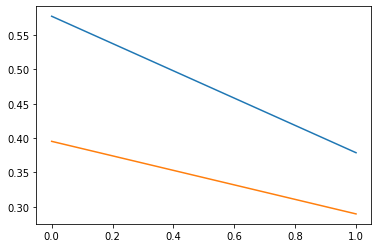

In [0]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [0]:
history.history['val_loss']

[0.3952200537924469, 0.2894777104007362]

In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [38]:
test = [
    'hi there',
    'hell',
    'presentation please fin',
    'please find at',
    'please gra',
    'have a nice we',
    'let me ',
    'promotion congrats ',
    'christmas Merry ',
    'please rev',
    'please ca',
    'thanks fo',
    'Let me kno',
    'Let me know if y',
    'this soun',
    'is this call going t'
]
  
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,hi there,is the message. did you get the same time and sent you yesterday?
1,hell,"ed is the call's ended and i'll be available for the 2:30 call. best, jeff"
2,presentation please fin,the following link:
3,please find at,"the attached file. thanks, tim"
4,please gra,me to answer a new poll on the website!
5,have a nice we,in the office today. any isssues to deal with for the stagecoach? phillip
6,let me,me know whether or not you will be there. please try to make it by 9:15.
7,promotion congrats,years rules so a call about the bleeding in california electricity?
8,christmas merry,of the picks:
9,please rev,ed the attached articles:


In [0]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
model_json = inf_model.to_json()

import json
with open("/content/drive/My Drive/Colab Notebooks/smart_compose_200215_3.json", "w") as json_file:
    json.dump(json.loads(model_json), json_file, indent=4)

# serialize weights to HDF5
inf_model.save_weights("/content/drive/My Drive/Colab Notebooks/smart_compose_200215_3.h5")

In [55]:
t = %sx read -p ''
translate(t[0].lower(), encoder_model, inf_model)

'  attached the following documents: thanks, lydia x39338'